# Stress Testing

## Abstract

Financial markets are unpredictable, and crises such as the 2008 crash and the COVID-19 downturn have exposed flaws in traditional risk models. Conventional stress testing methods, such as historical analysis and Monte Carlo simulations, struggle to anticipate new and unprecedented crises because of their reliance on past data and simplified assumptions. These methods underestimate fat-tailed risks and fail to model the complex relationships between assets and macroeconomic factors, making them ineffective for real-world risk management.

This project leverages deep generative models-Conditional Variational Autoencoder (cVAE) and Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP), to generate synthetic crisis scenarios based on macroeconomic conditions such as inflation, interest rates, and volatility. Unlike traditional methods, these models dynamically simulate extreme market movements, providing a more adaptive and data-driven approach to stress testing.

The model is applied to Warren Buffett's Q4 2019 portfolio, a well-diversified and extensively studied set of investments. The model assesses risk under conditions similar to the COVID-19 collapse, evaluating how artificial intelligence-generated scenarios compare to actual market disruptions. Key metrics such as Value at Risk (VaR), Expected Shortfall (ES), Earth Mover's Distance (EMD), and Jensen-Shannon Divergence (JSD) quantify the model's ability to capture market extremes. In addition, K-Means clustering in latent space helps to classify different levels of financial risk.

The results aim to show that deep generative models can capture extreme market conditions that traditional models fail to represent. WGAN-GP refines the synthetic scenarios by producing more realistic financial stress conditions, while cVAE enables the generation of conditional scenarios based on macroeconomic trends. In addition, K-Means clustering is applied to the latent space to classify stress scenarios into different levels of risk, identifying potential black swan financial events.

Future work includes expanding datasets, optimizing training efficiency, and validating performance across multiple financial crises. This AI-driven approach has strong potential to improve risk management for investors and financial institutions by providing a more proactive tool to anticipate financial crises.

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from fredapi import Fred

import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.losses import mse

from sklearn.preprocessing import StandardScaler

from scipy.stats import wasserstein_distance, ks_2samp, entropy

from sklearn.cluster import KMeans

2025-03-03 01:27:19.788774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 01:27:19.798085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740983239.807880   84470 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740983239.810839   84470 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 01:27:19.822286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]#12288)],
        )
        print("GPU memory limited to 8GB")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

GPU memory limited to 8GB


In [ ]:
SEED_RANDOM = 101
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

EPOCHS = 500
EPOCHS_GENERATOR = EPOCHS_WGAN = 500
EPOCHS_CVAE = 50
LATENT_DIM = 2
NOISE_DIM = 10

NUM_SCENARIOS = 1000

## Data

### Parameters

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [5]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

In [6]:
start_date = "2004-01-01"
backtest_date = "2020-02-01"
backtest_end = "2020-04-01"
end_date = "2021-01-01"

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

### Download Market Data

In [7]:
# Download market data once (Close prices and Volume)
market_data = yf.download(tickers, start=pre_start_date, end=end_date, progress=False)
market_data

YF.download() has changed argument auto_adjust default to True


Price            Close                                                 \
Ticker            AAPL        AMZN         AXP        BAC        BIIB   
Date                                                                    
2003-01-02    0.222693    0.978500   23.394028  20.893522   34.340000   
2003-01-03    0.224197    1.026000   23.476967  20.763454   33.689999   
2003-01-06    0.224197    1.035000   24.299929  21.062035   34.230000   
2003-01-07    0.223445    1.077500   23.974567  21.094530   34.240002   
2003-01-08    0.218931    1.051000   23.795940  21.008816   33.029999   
...                ...         ...         ...        ...         ...   
2020-12-24  128.905762  158.634506  111.246811  27.166573  248.889999   
2020-12-28  133.516205  164.197998  112.204277  27.320719  244.149994   
2020-12-29  131.738434  166.100006  111.995712  27.211908  243.460007   
2020-12-30  130.615158  164.292496  113.218628  27.184708  243.580002   
2020-12-31  129.609070  162.846497  114.621674  27.483936  244.860001   

Price                                                                 ...  \
Ticker             BK        COST         DVA         GL          GS  ...   
Date                                                                  ...   
2003-01-02  15.763548   19.460596    8.363333  13.479934   50.043800  ...   
2003-01-03  15.869802   18.950766    8.460000  13.487141   50.568317  ...   
2003-01-06  16.663607   19.178848    8.483333  13.703858   52.450798  ...   
2003-01-07  16.588596   19.487425    8.416667  13.544936   52.235237  ...   
2003-01-08  15.938553   19.655132    8.376667  13.508811   50.956314  ...   
...               ...         ...         ...        ...         ...  ...   
2020-12-24  36.113949  346.373871  115.129997  89.606995  230.967056  ...   
2020-12-28  36.465935  352.530304  115.449997  90.012245  234.059738  ...   
2020-12-29  36.465935  354.107330  116.000000  88.921936  232.635132  ...   
2020-12-30  36.685921  355.750977  115.500000  89.935043  233.933517  ...   
2020-12-31  37.345905  357.964600  117.400002  91.623566  237.774551  ...   

Price        Volume                                                         \
Ticker          PNC     SIRI       SPY       SU     TEVA      TRV      UPS   
Date                                                                         
2003-01-02   792500   225260  44516300   864800  6000400   833000  2805000   
2003-01-03  1109100   117150  32222600   757200  4711600   961100  1935500   
2003-01-06  1756200   162380  40984500   718000  7149600  1200300  3052500   
2003-01-07  1597900   641390  38640400   631600  6454800  1441100  2370400   
2003-01-08  1335400   553830  38702200   751200  3277400  1385300  1680900   
...             ...      ...       ...      ...      ...      ...      ...   
2020-12-24   518800   556740  26457900  2079400  3108700   416800  1006100   
2020-12-28  1686800  1497000  39000400  3881700  7786000  1100300  1861700   
2020-12-29  1015400  1752900  53680500  5874800  6494700   859000  2864600   
2020-12-30  1002600  1574270  49455300  4962700  5919500  1253800  3107100   
2020-12-31  1353900  1246820  78520700  4239700  8103700   970200  2349400   

Price                                    
Ticker          USB      VRSN       WFC  
Date                                     
2003-01-02  5131000   6949000   9904200  
2003-01-03  3398700   3147300   7808000  
2003-01-06  6704900   5064200   8097400  
2003-01-07  5067900  10772800   6556200  
2003-01-08  3579900  10515000   8071000  
...             ...       ...       ...  
2020-12-24  1980900    139900  14443700  
2020-12-28  4330800    296500  21658500  
2020-12-29  4083400    287100  19584400  
2020-12-30  3157400    248500  18519300  
2020-12-31  3778500    311100  21081200  

[4532 rows x 150 columns]

In [8]:
close_data = market_data["Close"]
returns_all = np.log(close_data / close_data.shift(1))

# Use returns only from start_date to backtest_date for training
returns_train = returns_all.loc[start_date:backtest_date]
returns_test = returns_all.loc[backtest_date:backtest_end]

# Scale returns
returns_scaler = StandardScaler()
returns_train_scaled = returns_train.copy()
returns_train_scaled.iloc[:] = returns_scaler.fit_transform(returns_train_scaled)

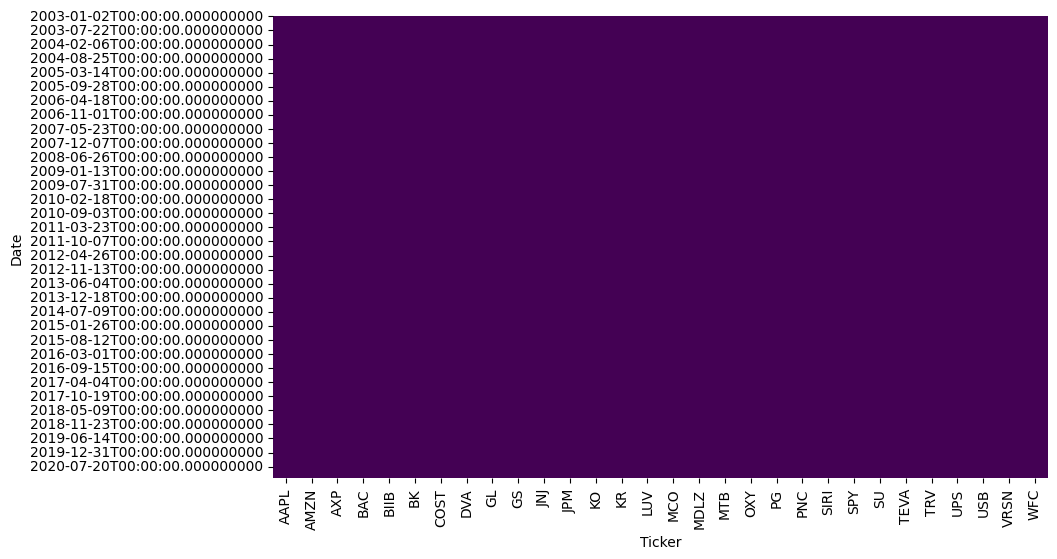

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(returns_all.isnull(), cmap="viridis", cbar=False)
plt.show()

In [10]:
returns_train.head()

Ticker,AAPL,AMZN,AXP,BAC,BIIB,BK,COST,DVA,GL,GS,...,PNC,SIRI,SPY,SU,TEVA,TRV,UPS,USB,VRSN,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,-0.004220,-0.013777,-0.010002,-0.016801,0.006518,-0.009404,-0.023402,0.012992,0.000439,-0.016339,...,-0.004394,0.189678,-0.000449,0.016229,0.020249,-0.001262,-0.012146,-0.007314,0.002451,-0.012302
2004-01-05,0.040973,0.026055,0.008758,0.002904,0.004322,0.040908,-0.004692,0.011075,0.007016,0.000515,...,-0.013487,-0.087487,0.010819,0.008990,0.027105,0.002522,0.003794,-0.009999,0.045462,0.004803
2004-01-06,-0.003617,-0.004516,0.001659,-0.001640,0.039376,0.015387,0.011278,-0.012341,-0.002625,-0.005987,...,0.008336,-0.040822,0.000978,0.018887,-0.016277,-0.007585,-0.006105,-0.015012,0.045722,-0.003256
2004-01-07,0.022384,-0.021539,0.002898,-0.002276,0.055444,-0.035184,0.014123,-0.004063,-0.001096,0.020797,...,-0.002956,-0.058209,0.003370,-0.017720,-0.003940,0.000000,-0.003271,-0.000704,-0.017470,-0.010179
2004-01-08,0.033517,-0.032507,-0.002898,0.000506,0.011214,-0.001195,0.004842,-0.006894,0.000000,0.001216,...,-0.003150,0.058209,0.003976,-0.027582,-0.002233,0.006325,-0.008226,-0.006710,0.043933,-0.000346


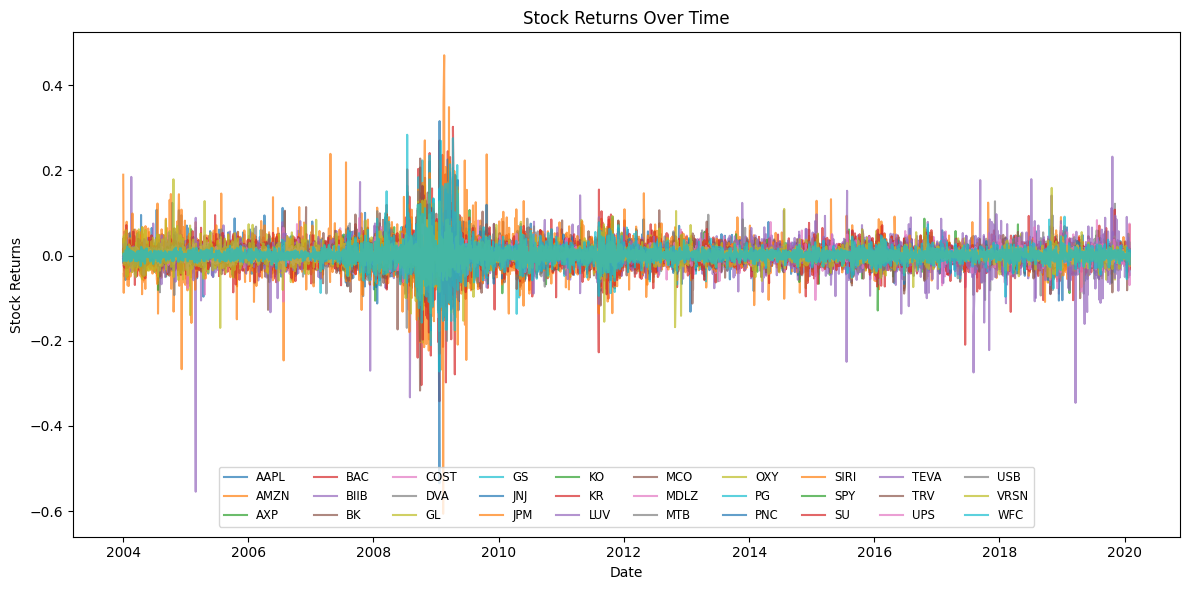

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

for ticker in returns_train.columns:
    ax.plot(returns_train.index, returns_train[ticker], label=ticker, alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.15), fontsize='small', ncol=10)
fig.tight_layout()
plt.show()

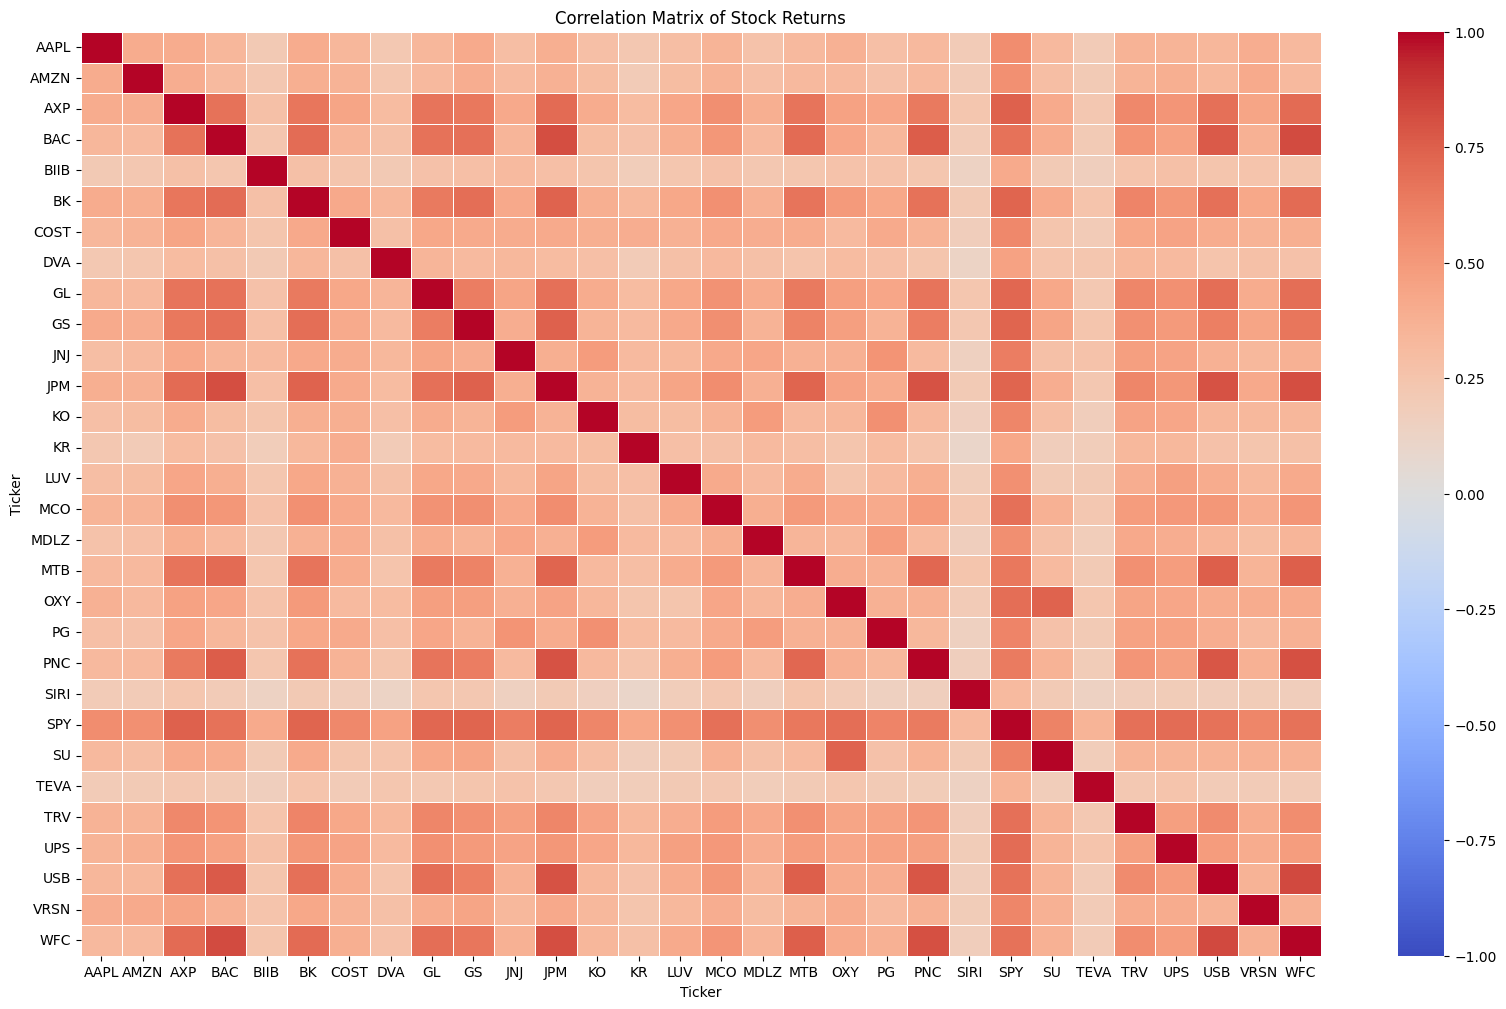

In [12]:
returns_corr_matrix = returns_train.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(returns_corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Stock Returns")
plt.show()

### Download and Prepare Macroeconomic Indicators

In [13]:
with open("key_fred.txt", "r") as file:
    key_fred = file.read().strip()

fred = Fred(api_key=key_fred)

# Download FRED series
inflation = fred.get_series("CPIAUCSL", start_date=pre_start_date, end_date=end_date)
fed_funds = fred.get_series("FEDFUNDS", start_date=pre_start_date, end_date=end_date)
unemployment = fred.get_series("UNRATE", start_date=pre_start_date, end_date=end_date)
short_term = fred.get_series("DGS3MO", start_date=pre_start_date, end_date=end_date)
long_term = fred.get_series("DGS10", start_date=pre_start_date, end_date=end_date)

In [14]:
macro_df = pd.concat(
    [inflation, fed_funds, unemployment, short_term, long_term], axis=1
)
macro_df.ffill(inplace=True)
macro_df.columns = ["inflation", "fed_funds", "unemployment", "short_term", "long_term"]

# VIX
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)
vix_col = "Adj Close" if "Adj Close" in vix_df.columns else "Close"
if isinstance(vix_df.columns, pd.MultiIndex):
    vix_data = vix_df[("Close", "^VIX")].rename("vix")
else:
    vix_data = vix_df["Close"].rename("vix")
macro_df = pd.concat([macro_df, vix_data], axis=1)

# EURUSD exchange rate
fx_df = yf.download("EURUSD=X", start=start_date, end=end_date, progress=False)
if isinstance(fx_df.columns, pd.MultiIndex):
    fx_data = fx_df[("Close", "EURUSD=X")].rename("eurusd")
else:
    fx_data = fx_df["Close"].rename("eurusd")
macro_df = pd.concat([macro_df, fx_data], axis=1)

# Average Volume: use volume from market_data
volume_df = market_data["Volume"].dropna()
avg_volume = volume_df.mean(axis=1).rename("avg_volume")
macro_df = pd.concat([macro_df, avg_volume], axis=1)

# Historical Volatility: 30-day rolling standard deviation of average returns
volatility = returns_all.rolling(window=30).std().mean(axis=1).rename("volatility")
# Restrict volatility to the period from start_date onward
volatility = volatility.loc[start_date:end_date]
macro_df = pd.concat([macro_df, volatility], axis=1)

# S&P 500 Index
sp500_df = yf.download("^GSPC", start=pre_start_date, end=end_date, progress=False)
sp500_col = "Adj Close" if "Adj Close" in sp500_df.columns else "Close"
if isinstance(sp500_df.columns, pd.MultiIndex):
    sp500_data = sp500_df[("Close", "^GSPC")].rename("sp500")
else:
    sp500_data = sp500_df["Close"].rename("sp500")
macro_df = pd.concat([macro_df, sp500_data], axis=1)

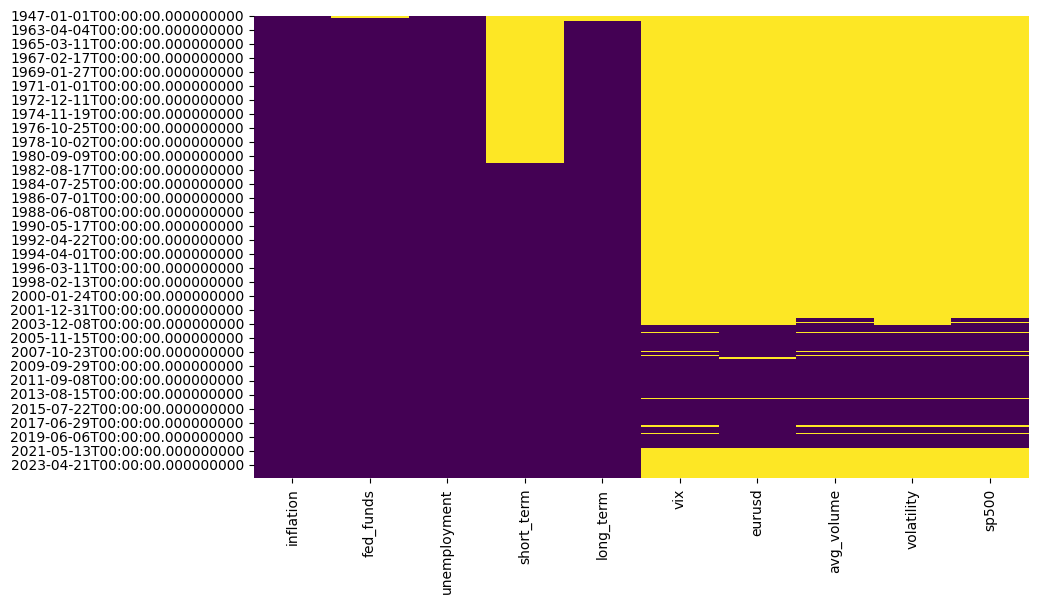

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(macro_df.isnull(), cmap="viridis", cbar=False)
plt.show()

In [16]:
macro_df = macro_df.fillna(method="ffill")

macro_train = macro_df.loc[start_date:backtest_date]
macro_test = macro_df.loc[backtest_date:backtest_end]

macro_train = macro_train.reindex(returns_train.index)
macro_test = macro_test.reindex(returns_test.index)

# Scale macro indicators
macro_scaler = StandardScaler()
macro_train_scaled = macro_scaler.fit_transform(macro_train)
macro_test_scaled = macro_scaler.transform(macro_test)

/tmp/ipykernel_84470/2571005151.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df = macro_df.fillna(method="ffill")


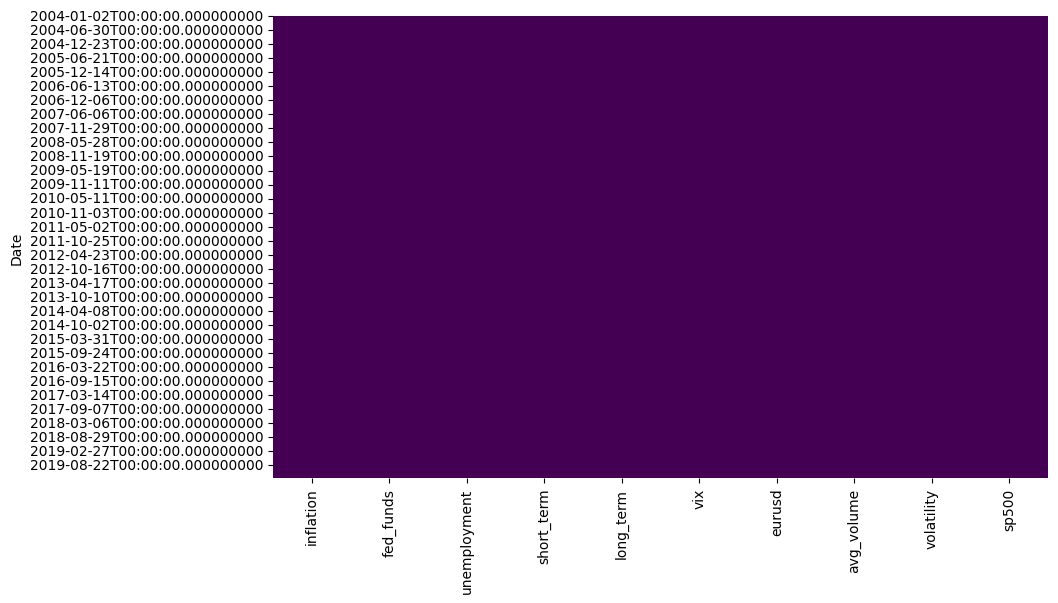

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(macro_train.isnull(), cmap="viridis", cbar=False)
plt.show()

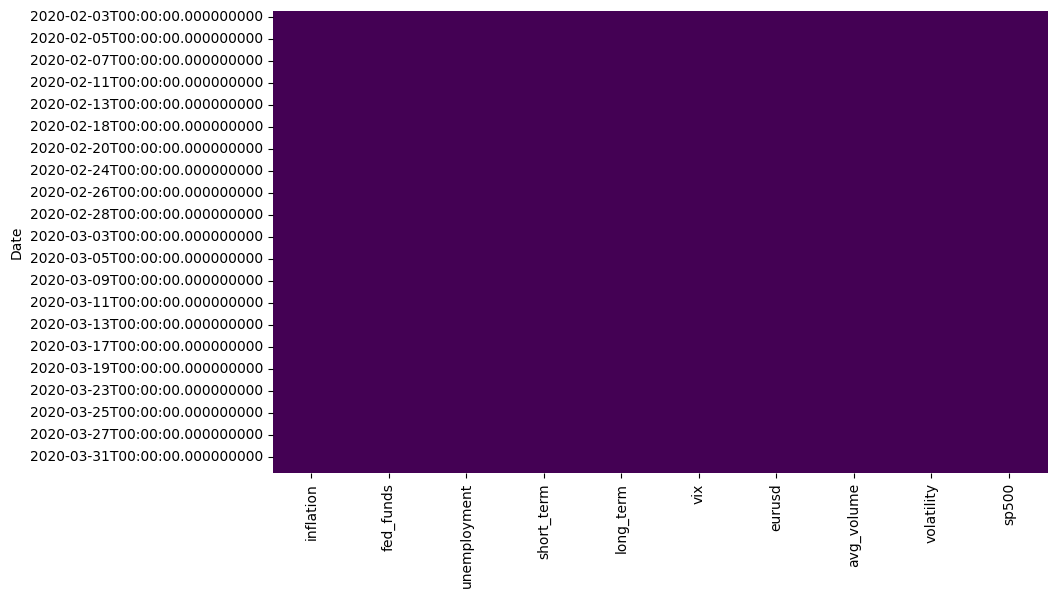

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(macro_test.isnull(), cmap="viridis", cbar=False)
plt.show()

In [19]:
macro_train.head()

,inflation,fed_funds,unemployment,short_term,long_term,vix,eurusd,avg_volume,volatility,sp500
Date,,,,,,,,,,
2004-01-02,186.3,1.0,5.7,0.93,4.38,18.219999,1.258194,1.457772e+07,0.012653,1108.479980
2004-01-05,186.3,1.0,5.7,0.91,4.41,17.490000,1.268698,2.663946e+07,0.012885,1122.219971
2004-01-06,186.3,1.0,5.7,0.91,4.29,16.730000,1.272103,2.645765e+07,0.012927,1123.670044
2004-01-07,186.3,1.0,5.7,0.91,4.27,15.500000,1.264095,3.189847e+07,0.013174,1126.329956
2004-01-08,186.3,1.0,5.7,0.88,4.27,15.610000,1.277498,2.793242e+07,0.012869,1131.920044


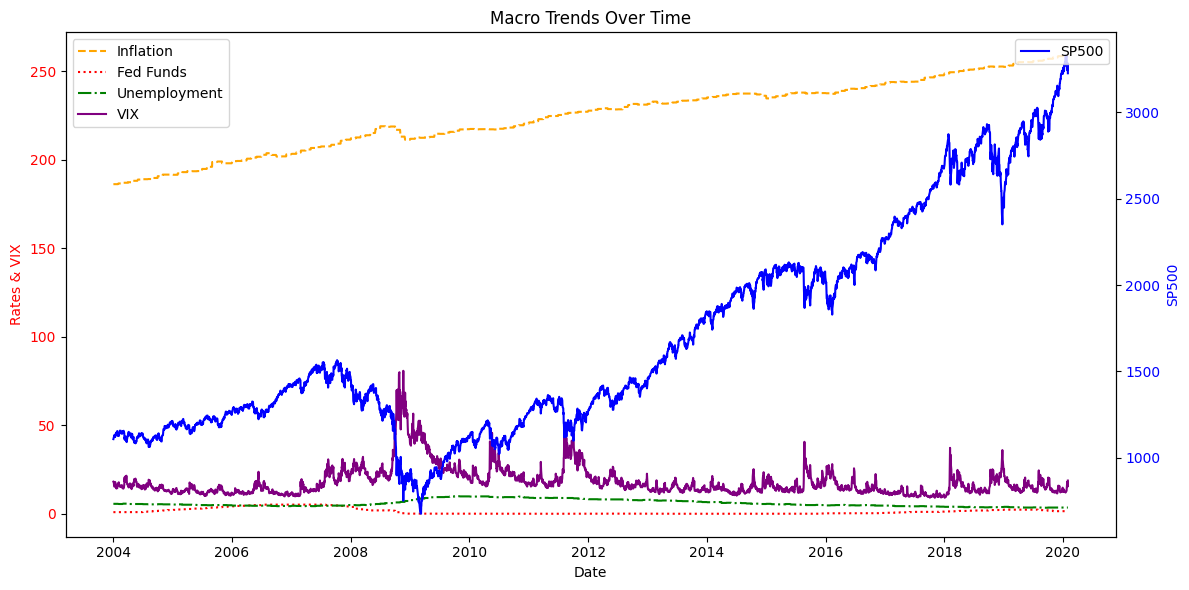

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(macro_train.index, macro_train['inflation'], color='orange', linestyle='dashed', label='Inflation')
ax1.plot(macro_train.index, macro_train['fed_funds'], color='red', linestyle='dotted', label='Fed Funds')
ax1.plot(macro_train.index, macro_train['unemployment'], color='green', linestyle='dashdot', label='Unemployment')
ax1.plot(macro_train.index, macro_train['vix'], color='purple', linestyle='solid', label='VIX')
ax1.tick_params(axis='y', labelcolor='red')

# Right y: Plot SP500
ax2 = ax1.twinx()
ax2.set_ylabel('SP500', color='blue')
ax2.plot(macro_train.index, macro_train['sp500'], color='blue', label='SP500')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

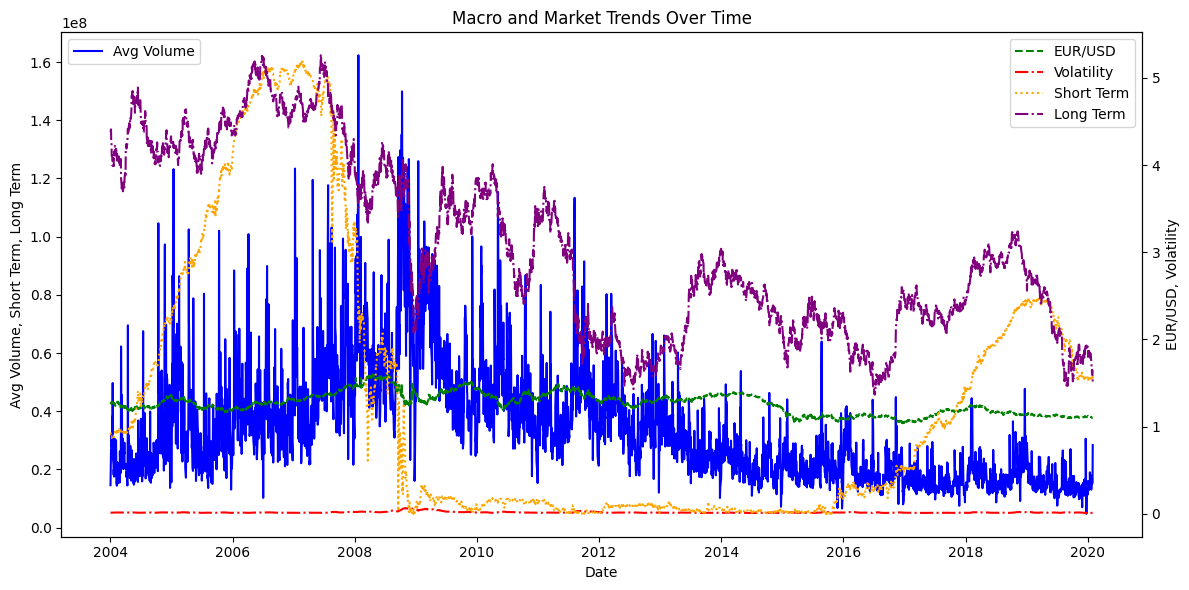

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Average Volume
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Volume, Short Term, Long Term')
ax1.plot(macro_train.index, macro_train['avg_volume'], label='Avg Volume', color='blue')
ax1.tick_params(axis='y')

# Right y: Plot EUR/USD, Volatility, Short Term and Long Term
ax2 = ax1.twinx()
ax2.set_ylabel('EUR/USD, Volatility')
ax2.plot(macro_train.index, macro_train['eurusd'], linestyle='dashed', label='EUR/USD', color='green')
ax2.plot(macro_train.index, macro_train['volatility'], linestyle='dashdot', label='Volatility', color='red')
ax2.plot(macro_train.index, macro_train['short_term'], linestyle='dotted', label='Short Term', color='orange')
ax2.plot(macro_train.index, macro_train['long_term'], linestyle='dashdot', label='Long Term', color='purple')
ax2.tick_params(axis='y')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Macro and Market Trends Over Time')
fig.tight_layout()
plt.show()

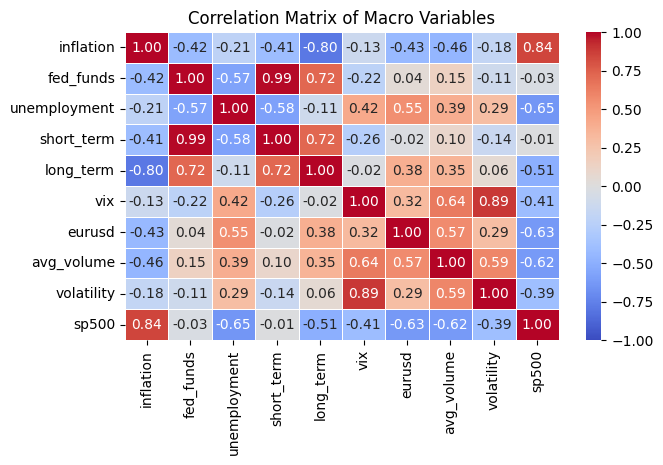

In [22]:
corr_matrix = macro_train.corr()

plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Macro Variables")
plt.show()

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [37]:
import keras.saving

@keras.saving.register_keras_serializable()
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var + 1e-8) * epsilon

@keras.saving.register_keras_serializable()
class ReconstructionLossLayer(layers.Layer):
    def call(self, inputs):
        x, x_pred = inputs
        loss = K.mean(mse(x, x_pred))
        self.add_loss(loss)
        return x_pred

@keras.saving.register_keras_serializable()
class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.add_loss(tf.reduce_mean(kl_loss))
        return z_mean

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [24]:
def build_conditional_vae(input_dim, macro_dim, intermediate_dim=256, latent_dim=2):
    # Encoder
    x_input = layers.Input(shape=(input_dim,), name="returns_input")
    h = layers.Dense(intermediate_dim, activation="relu")(x_input)
    h = layers.Dropout(0.1)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
    z_mean = KLDivergenceLayer()([z_mean, z_log_var])
    z = SamplingLayer(name="z")([z_mean, z_log_var])
    encoder = Model(x_input, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    cond_input = layers.Input(shape=(macro_dim,), name="macro_input")
    decoder_input = layers.Concatenate(name="concat_decoder")([z, cond_input])
    d = layers.Dense(intermediate_dim, activation="relu")(decoder_input)
    d = layers.Dropout(0.1)(d)
    d = layers.Dense(intermediate_dim // 2, activation="relu")(d)
    outputs = layers.Dense(input_dim, activation="linear")(d)
    decoder = Model([z, cond_input], outputs, name="decoder")

    # Conditional VAE Model
    vae_output = decoder([encoder(x_input)[2], cond_input])
    x_pred = ReconstructionLossLayer()([x_input, vae_output])
    cvae = Model([x_input, cond_input], x_pred, name="cvae")

    # Compile the model
    cvae.compile(optimizer="adam")

    return encoder, decoder, cvae

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [25]:
def build_conditional_generator(noise_dim, macro_dim, latent_dim):
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_gen")
    x = layers.Concatenate(name="concat_gen")([noise_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_latent = layers.Dense(latent_dim, name="latent_generated")(x)
    model = Model(
        [noise_input, macro_input], output_latent, name="conditional_generator"
    )
    return model


def build_conditional_critic(latent_dim, macro_dim):
    latent_input = layers.Input(shape=(latent_dim,), name="latent_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_critic")
    x = layers.Concatenate(name="concat_critic")([latent_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_score = layers.Dense(1, name="critic_score")(x)
    model = Model([latent_input, macro_input], output_score, name="conditional_critic")
    return model


def gradient_penalty_cond(critic, real_latent, fake_latent, macro, batch_size):
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated_latent = alpha * real_latent + (1 - alpha) * fake_latent
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_latent)
        interpolated_output = critic([interpolated_latent, macro])
    grads = gp_tape.gradient(interpolated_output, [interpolated_latent])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def train_conditional_wgan_gp(
    generator,
    critic,
    real_latent,
    real_macro,
    noise_dim,
    batch_size=32,
    epochs=EPOCHS_WGAN,
    critic_iterations=5,
    lambda_gp=10.0,
):
    # Use lower learning rate and clipnorm for stability
    gen_optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )
    critic_optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (real_latent.astype("float32"), real_macro.astype("float32"))
    )
    dataset = dataset.shuffle(1024).batch(batch_size)

    for epoch in range(1, epochs+1):
        for latent_batch, macro_batch in dataset:
            current_batch_size = tf.shape(macro_batch)[0]
            for _ in range(critic_iterations):
                noise = tf.random.normal([current_batch_size, noise_dim])
                with tf.GradientTape() as tape:
                    fake_latent = generator([noise, macro_batch])
                    critic_real = critic([latent_batch, macro_batch])
                    critic_fake = critic([fake_latent, macro_batch])
                    gp = gradient_penalty_cond(
                        critic,
                        latent_batch,
                        fake_latent,
                        macro_batch,
                        current_batch_size,
                    )
                    critic_loss = (
                        tf.reduce_mean(critic_fake)
                        - tf.reduce_mean(critic_real)
                        + lambda_gp * gp
                    )
                grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            noise = tf.random.normal([current_batch_size, noise_dim])
            with tf.GradientTape() as tape:
                fake_latent = generator([noise, macro_batch])
                gen_loss = -tf.reduce_mean(critic([fake_latent, macro_batch]))
            grads = tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}: Critic Loss = {critic_loss.numpy():.4f}, Gen Loss = {gen_loss.numpy():.4f}")

    return generator

## Metrics and Validation Functions

In [26]:
def compute_portfolio_returns(returns_array, weights):
    return returns_array.dot(weights)


def calculate_var_es(portfolio_returns, alpha=5):
    var_threshold = np.percentile(portfolio_returns, alpha)
    es = portfolio_returns[portfolio_returns <= var_threshold].mean()
    return var_threshold, es


def select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5):
    portfolio_returns = compute_portfolio_returns(synthetic_returns, portfolio_weights)
    var_threshold, es = calculate_var_es(portfolio_returns, alpha)
    extreme_indices = np.where(portfolio_returns <= var_threshold)[0]
    extreme_scenarios = synthetic_returns[extreme_indices]
    return extreme_scenarios, var_threshold, es, portfolio_returns


def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

## Clustering Function for Latent Space Scenarios

In [27]:
def cluster_extreme_latent(z_codes, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED_RANDOM)
    clusters = kmeans.fit_predict(z_codes)
    global_center = np.mean(z_codes, axis=0)
    distances = np.linalg.norm(kmeans.cluster_centers_ - global_center, axis=1)
    extreme_cluster = np.argmax(distances)
    extreme_indices = np.where(clusters == extreme_cluster)[0]
    return extreme_indices, clusters, kmeans.cluster_centers_

## Training and Stress Testing

In [28]:
n_samples = min(returns_train_scaled.shape[0], macro_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
macro_train_scaled = macro_train_scaled[:n_samples]

### VAE

In [ ]:
input_dim = returns_scaled.shape[1]
macro_dim = macro_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Input dim: {input_dim}")
print(f"Macro dim: {macro_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Input dim: 30
Macro dim: 10
Latent dim: 2
Noise dim: 10


In [30]:
print("Training Conditional VAE...")
encoder, decoder, cvae = build_conditional_vae(
    input_dim, macro_dim, intermediate_dim=256, latent_dim=latent_dim
)
cvae.fit([returns_scaled, macro_train_scaled], epochs=EPOCHS_CVAE, batch_size=32, verbose=1)
z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1740983248.517363   84470 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1740983249.648171   84766 service.cc:148] XLA service 0x74f944004280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740983249.648188   84766 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-03 01:27:29.667563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740983249.772654   84766 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-03 01:27:30.228541: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1082', 4 bytes spill stores, 4 bytes spill loads



 65/127 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.1324

I0000 00:00:1740983250.979854   84766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1226 
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.0256
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.0013
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.9451
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.9347
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.9039
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.8888
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.9012
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.8864
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.8839
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.8634
Epoch 12/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.8717
Epoch 13/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.8638
Epoch 14/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 0.8642
Epoch 15/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 

### WGAN-GP

In [ ]:
print("Training Conditional WGAN-GP...")
generator = build_conditional_generator(noise_dim, macro_dim, latent_dim)
critic = build_conditional_critic(latent_dim, macro_dim)
generator = train_conditional_wgan_gp(
    generator,
    critic,
    z_mean_train,
    macro_train_scaled,
    noise_dim,
    batch_size=32,
    epochs=EPOCHS,
    critic_iterations=5,
    lambda_gp=10.0,
)

Training Conditional WGAN-GP...


2025-03-02 20:38:13.722236: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 4.8586, Gen Loss = -0.2260


2025-03-02 20:38:42.309354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 20:39:39.078356: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 20:41:31.968627: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 20:44:59.816869: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 20:51:52.996135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 21:05:21.601814: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100: Critic Loss = -0.0047, Gen Loss = -1.1841


2025-03-02 21:33:02.091080: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200: Critic Loss = 0.0040, Gen Loss = -1.2212


2025-03-02 22:29:40.512596: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300: Critic Loss = -0.0101, Gen Loss = -0.9982
Epoch 400: Critic Loss = -0.0056, Gen Loss = -0.9644
Epoch 500: Critic Loss = 0.0046, Gen Loss = -0.9182


### Save Models

In [31]:
encoder.save("models/encoder_model.keras")
decoder.save("models/decoder_model.keras")
cvae.save("models/cvae_model.keras")
generator.save("models/generator_model.keras")
critic.save("models/critic_model.keras")

In [38]:
from tensorflow.keras.models import load_model

# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer
}

# Load the models with the custom layer
encoder = load_model("models/encoder_model.keras", custom_objects=custom_objects)
decoder = load_model("models/decoder_model.keras", custom_objects=custom_objects)
cvae = load_model("models/cvae_model.keras", custom_objects=custom_objects)
generator = load_model("models/generator_model.keras", custom_objects=custom_objects)
critic = load_model("models/critic_model.keras", custom_objects=custom_objects)

### Generate New Synthetic Scenarios

In [41]:
num_samples_to_generate = NUM_SCENARIOS
idx = np.random.choice(macro_train_scaled.shape[0], num_samples_to_generate, replace=True)
macro_conditions_sample = macro_train_scaled[idx]
macro_conditions_sample = tf.convert_to_tensor(
    macro_conditions_sample, dtype=tf.float32
)
noise = tf.random.normal([num_samples_to_generate, noise_dim])
generated_latent = generator([noise, macro_conditions_sample]).numpy()

# Conditional decoding
synthetic_returns_scaled = decoder.predict([generated_latent, macro_conditions_sample])
synthetic_returns = returns_scaler.inverse_transform(synthetic_returns_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 


#### Stress Testing

In [42]:
portfolio_weights = np.array([1 / len(tickers)] * len(tickers))
extreme_scenarios, var_threshold, es, synthetic_portfolio_returns = (
    select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5)
)
historical_portfolio_returns = compute_portfolio_returns(
    returns_test.values, portfolio_weights
)
emd_distance = wasserstein_distance(
    historical_portfolio_returns, synthetic_portfolio_returns
)

hist_real, bin_edges = np.histogram(returns_test.values[:, 0], bins=50, density=True)
hist_syn, _ = np.histogram(synthetic_returns[:, 0], bins=bin_edges, density=True)
js_div = jensen_shannon_divergence(hist_real + 1e-8, hist_syn + 1e-8)
ks_stat, ks_pvalue = ks_2samp(returns_test.values[:, 0], synthetic_returns[:, 0])


def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]


autocorr_real = np.mean(
    [autocorr(returns_test.values[:, i]) for i in range(returns_test.values.shape[1])]
)
autocorr_syn = np.mean(
    [autocorr(synthetic_returns[:, i]) for i in range(synthetic_returns.shape[1])]
)

extreme_indices_cluster, clusters, cluster_centers = cluster_extreme_latent(
    generated_latent, n_clusters=3
)

#### Stress Testing Results

In [43]:
print("--- Stress Testing Results ---")
print(f"VaR (5th percentile): {var_threshold:.4f}")
print(f"Expected Shortfall: {es:.4f}")
print(f"Number of extreme scenarios (VaR): {extreme_scenarios.shape[0]}")
print(f"Earth Mover's Distance: {emd_distance:.4f}")
print(f"Jensen-Shannon Divergence (asset 1): {js_div:.4f}")
print(f"KS-test statistic (asset 1): {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
print(f"Mean autocorrelation lag-1: real = {autocorr_real:.4f}, synthetic = {autocorr_syn:.4f}")
print(f"Number of scenarios in extreme cluster (K-Means): {len(extreme_indices_cluster)}")

--- Stress Testing Results ---
VaR (5th percentile): -0.0067
Expected Shortfall: -0.0163
Number of extreme scenarios (VaR): 50
Earth Mover's Distance: 0.0324
Jensen-Shannon Divergence (asset 1): 0.3851
KS-test statistic (asset 1): 0.4956, p-value: 0.0000
Mean autocorrelation lag-1: real = -0.3152, synthetic = 0.0295
Number of scenarios in extreme cluster (K-Means): 3


## Visualization

### Histogram of Synthetic Portfolio Returns

- This graph helps compare the distribution of real and synthetic portfolio returns
- It highlights the Value at Risk (VaR) threshold, showing the probability of extreme losses

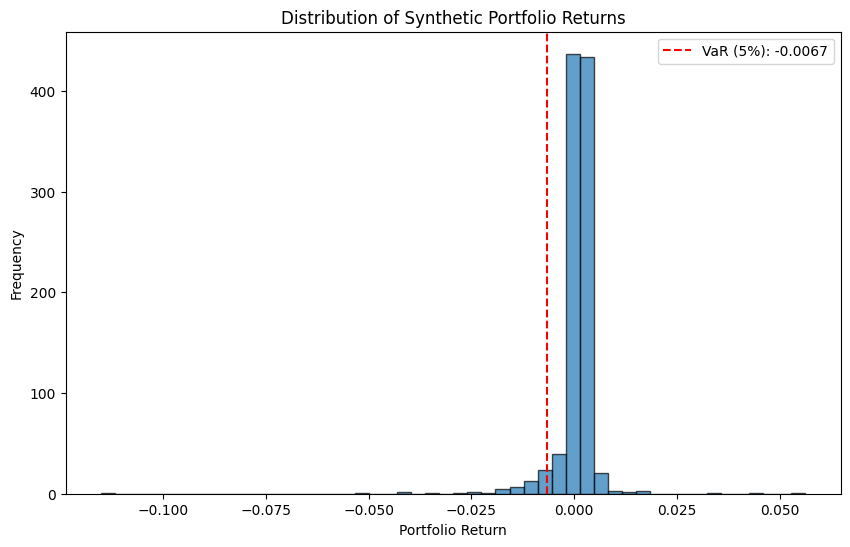

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(synthetic_portfolio_returns, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    var_threshold, color="r", linestyle="--", label=f"VaR (5%): {var_threshold:.4f}"
)
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.title("Distribution of Synthetic Portfolio Returns")
plt.legend()
plt.show()

### Heatmap of Extreme Scenarios (VaR)

- This visualization identifies which assets are most impacted in extreme market conditions
- It helps understand how different stocks contribute to high-risk scenarios

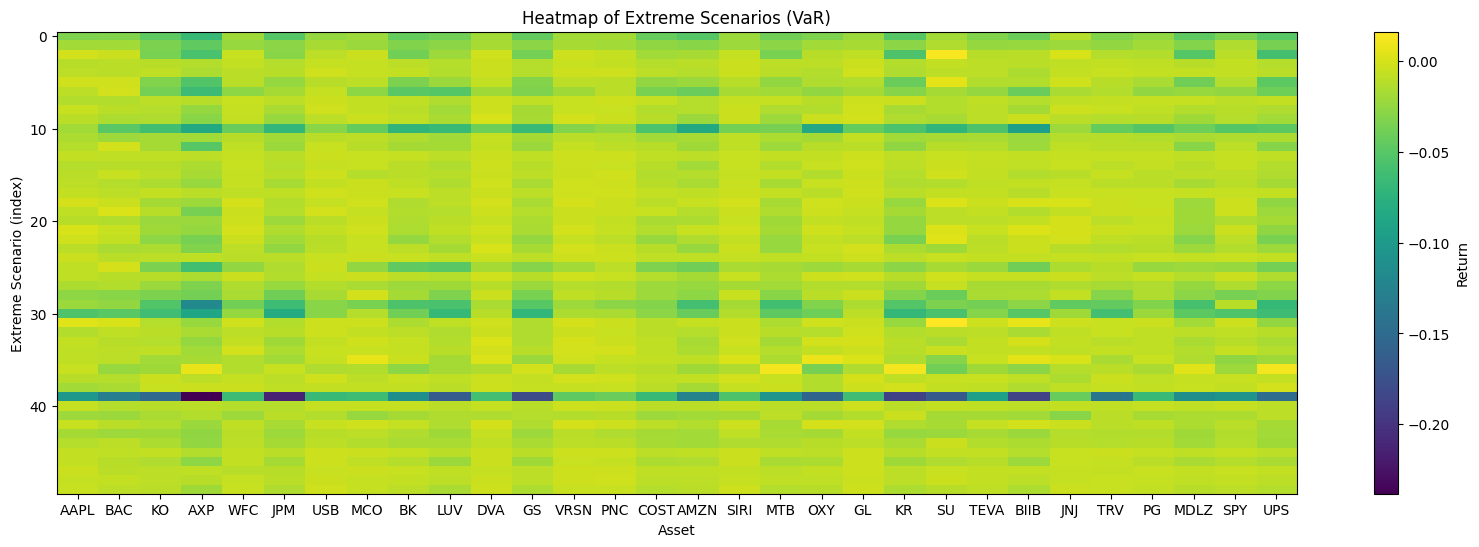

In [45]:
plt.figure(figsize=(20, 6))
plt.imshow(extreme_scenarios, aspect="auto", cmap="viridis")
plt.colorbar(label="Return")
plt.xticks(ticks=np.arange(len(tickers)), labels=tickers)
plt.xlabel("Asset")
plt.ylabel("Extreme Scenario (index)")
plt.title("Heatmap of Extreme Scenarios (VaR)")
plt.show()

### Scatter Plot of Latent Space with Clusters

- This plot represents different generated market scenarios in a latent space
- It clusters normal, moderate, and extreme financial conditions, helping to identify outliers associated with potential market crashes

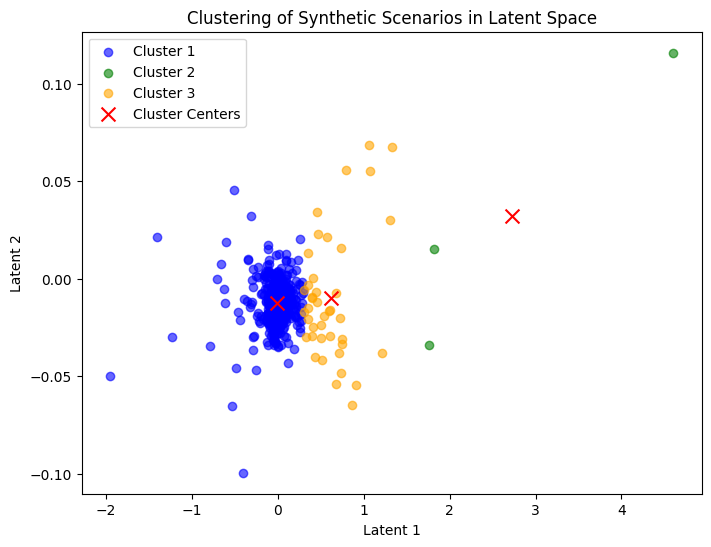

In [46]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "orange"]
cluster_colors = [colors[c] for c in clusters]
for i, color in enumerate(colors):
    plt.scatter(
        generated_latent[clusters == i, 0],
        generated_latent[clusters == i, 1],
        c=color,
        alpha=0.6,
        label=f"Cluster {i+1}",
    )
plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c="red",
    s=100,
    marker="x",
    label="Cluster Centers",
)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Clustering of Synthetic Scenarios in Latent Space")
plt.legend()
plt.show()

## Test

In [ ]:
macro_test_scaled = macro_scaler.transform(macro_test)
backtest_dates = returns_test.index

backtest_results = []
for i in range(len(backtest_dates) - 1):
    train_end_date = backtest_dates[i]
    forecast_date = backtest_dates[i + 1]

    idx = i
    macro_condition_np = macro_test_scaled[idx]

    macro_condition = tf.convert_to_tensor(
        np.atleast_2d(macro_condition_np), dtype=tf.float32
    )
    macro_condition = tf.repeat(macro_condition, repeats=NUM_SCENARIOS, axis=0)

    noise = tf.random.normal([NUM_SCENARIOS, noise_dim])
    synthetic_latent = generator([noise, macro_condition]).numpy()

    synthetic_returns_scaled = decoder.predict([synthetic_latent, macro_condition])
    synthetic_returns = returns_scaler.inverse_transform(synthetic_returns_scaled)

    synthetic_returns_df = pd.DataFrame(synthetic_returns, columns=tickers)
    synthetic_portfolio_returns = compute_portfolio_returns(
        synthetic_returns_df, portfolio_weights
    )

    var_synth, es_synth = calculate_var_es(synthetic_portfolio_returns, alpha=5)

    hist_returns_df = returns_test.loc[forecast_date:forecast_date]
    hist_portfolio_return = compute_portfolio_returns(
        hist_returns_df, portfolio_weights
    ).iloc[0]

    backtest_results.append(
        {
            "forecast_date": forecast_date,
            "hist_portfolio_return": hist_portfolio_return,
            "synthetic_VaR": var_synth,
            "synthetic_ES": es_synth,
        }
    )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7

In [48]:
backtest_df = pd.DataFrame(backtest_results)
backtest_df.head()

,forecast_date,hist_portfolio_return,synthetic_VaR,synthetic_ES
0,2020-02-04,0.014224,-0.001319,-0.001392
1,2020-02-05,0.019076,0.001888,0.001866
2,2020-02-06,0.001681,0.002406,0.002399
3,2020-02-07,-0.006849,0.002356,0.002351
4,2020-02-10,0.002672,0.002362,0.002355


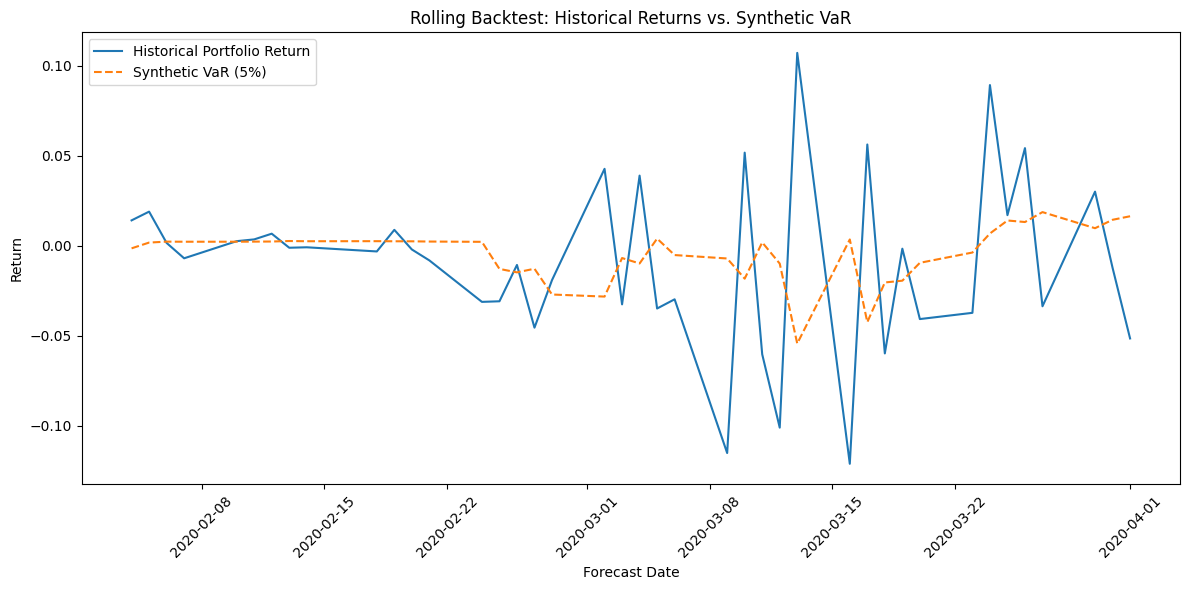

In [49]:
# Plot the historical portfolio returns and synthetic VaR over the backtest period
plt.figure(figsize=(12, 6))
plt.plot(
    backtest_df["forecast_date"],
    backtest_df["hist_portfolio_return"],
    label="Historical Portfolio Return",
    linestyle="-",
)
plt.plot(
    backtest_df["forecast_date"],
    backtest_df["synthetic_VaR"],
    label="Synthetic VaR (5%)",
    linestyle="--",
)
plt.xlabel("Forecast Date")
plt.ylabel("Return")
plt.title("Rolling Backtest: Historical Returns vs. Synthetic VaR")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()